## Imports

In [1]:
%env CUDA_VISIBLE_DEVICES=0

env: CUDA_VISIBLE_DEVICES=0


In [2]:
import os
import sys
import time
import numpy as np
import pandas as pd
import selfies as sf
import torch
from tqdm import tqdm, trange
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [3]:
class GPUCONFIGS:
    def __init__(self):
        self.use_cuda = torch.cuda.is_available()
        self.device = torch.device('cuda:0' if self.use_cuda else 'cpu')
        if self.use_cuda: torch.cuda.set_device(self.device)
        
gpuconfigs = GPUCONFIGS()
print(torch.cuda.current_device())

0


In [4]:
REBADD_LIB_PATH = os.path.abspath(os.pardir)
if REBADD_LIB_PATH not in sys.path:
    sys.path = [REBADD_LIB_PATH] + sys.path

In [5]:
from rebadd.stackVAE import StackAugmentedVAE
from rebadd.datautils import GeneratorData

## Setting up the generator

### Loading data for the generator

In [6]:
class DATACONFIGS:
    def __init__(self):
        ## input
        self.input_dir = 'outputs_0_preprocess_data'
        self.train_data_path = os.path.join(self.input_dir, 'fragments_list.pkl')
        self.vocab_data_path = os.path.join(self.input_dir, 'vocabulary.csv')
        ## output
        self.output_dir = 'outputs_1_pretraining'
        assert os.path.exists(self.output_dir)

dataconfigs = DATACONFIGS()

In [7]:
gen_data = GeneratorData(pickle_data_path=dataconfigs.train_data_path,
                         vocabulary_path=dataconfigs.vocab_data_path,
                         use_cuda=gpuconfigs.use_cuda)

print(f"Number of training samples: {len(gen_data.data)}")
print(f"Number of vocabulary: {len(gen_data.vocabs)}")
print(f"Maximum of seqlen: {gen_data.max_seqlen}")

Number of training samples: 6291
Number of vocabulary: 7496
Maximum of seqlen: 38


## Initializing and training the generator

We will used stack augmented generative GRU as a generator. The model was trained to predict the next symbol from SMILES alphabet using the already generated prefix. Model was trained to minimize the cross-entropy loss between predicted symbol and ground truth symbol. Scheme of the generator when inferring new SMILES is shown below:

Initialize stack-augmented generative RNN:

In [8]:
kwargs_generator = {"input_size"         : gen_data.n_characters,
                    "output_size"        : gen_data.n_characters,
                    "max_seqlen"         : 44,
                    "hidden_size"        : 256,
                    "latent_size"        : 64,
                    "n_layers"           : 4,
                    "has_stack"          : True,
                    "stack_width"        : 256,
                    "stack_depth"        : 20,
                    "lr"                 : 0.001,
                    "use_cuda"           : gpuconfigs.use_cuda,
                    "device"             : gpuconfigs.device,
                    "optimizer_instance" : torch.optim.RMSprop}

In [9]:
my_generator = StackAugmentedVAE(**kwargs_generator)

If you want train the model from scratch, uncomment the lines below:

In [10]:
model_path = os.path.join(dataconfigs.output_dir, 'checkpoint.pth')
losses_path = os.path.join(dataconfigs.output_dir, 'losses.txt')

In [11]:
losses = my_generator.fit(gen_data, n_iterations=15000,
                          batch_size=32,
                          print_every=1000,
                          ckpt_every=1000,
                          model_path=model_path,
                          losses_path=losses_path)

Training in progress...:   7%|███████▉                                                                                                               | 1000/15000 [03:00<43:59,  5.30it/s]

[01000 (6.7%) 3m 0s], Loss_vae:3.885, Loss_rec:3.612, Loss_kld:12.788, Beta:0.067
selfies: [C][C][=C][C][=C][Branch2][Ring1][#Branch2][C][=Branch1][C][=O][N][C][C][O][C][=C][Branch1][C][F][C][=C][Branch1][C][F][C][=C][Ring1][Branch2][C][Ring1][N][C][=C][Ring2][Ring2][Ring1]
smiles: C1C=CC=C(C(=O)NC2COC3=C(F)C=C(F)C=C3C2)C=C1


Training in progress...:  13%|███████████████▊                                                                                                       | 2000/15000 [06:01<38:18,  5.66it/s]

[02000 (13.3%) 6m 1s], Loss_vae:2.631, Loss_rec:2.373, Loss_kld:2.751, Beta:0.133
selfies: [C][N][Branch1][=C][C][=Branch1][C][=O][C][=C][C][=C][C][=C][Ring1][=Branch1][F][S][=Branch1][C][=O][=Branch1][C][=O][C][=C][C][=C][S][Ring1][Branch1]
smiles: CN(C(=O)C1=CC=CC=C1F)S(=O)(=O)C2=CC=CS2


Training in progress...:  20%|███████████████████████▊                                                                                               | 3000/15000 [09:02<39:09,  5.11it/s]

[03000 (20.0%) 9m 2s], Loss_vae:2.045, Loss_rec:1.909, Loss_kld:0.853, Beta:0.200
selfies: [C][O][C][=C][C][=C][Branch2][#Branch1][C][N][N][=C][Branch1][C][C][C][=C][Ring1][=Branch1][C][=C][O][C][=C][Branch2][Ring2][Ring2][C][=C][C][=C][C][Branch1][C][O][=N][C][Branch1][S][N][C][C][C][Branch1][=Branch1][C][Branch1][C][N][=O][C][C][Ring1][=Branch2][=N][C][Ring1][S][=N][Ring2][Ring1][Ring2][C][Branch1][C][O][=C][Branch1][C][C][C][Branch1][C][O][=C][Ring2][Ring1][=N][C][Ring2][Ring1][S][Branch1][C][C][C][Ring2][Ring2][Branch1][=O][C][=C][Ring2][Ring2][S]
smiles: COC1=CC=C(N2N=C(C)C3=C2C=C4OC5=C(C6=CC=C7C(O)=NC(N8CCC(C(N)=O)CC8)=NC7=N6)C(O)=C(C)C(O)=C5C4(C)C3=O)C=C1


Training in progress...:  27%|███████████████████████████████▋                                                                                       | 4000/15000 [12:02<33:25,  5.48it/s]

[04000 (26.7%) 12m 2s], Loss_vae:1.694, Loss_rec:1.641, Loss_kld:0.236, Beta:0.267
selfies: [C][C][O][C][=Branch1][C][=O][C][=C][S][C][Branch1][=Branch2][C][C][=C][N][=C][NH1][Ring1][Branch1][C][=Branch1][C][=O][N][Ring2][Ring1][C][C][=C][C][=C][C][=C][C][=C][C][=C][Ring1][#Branch2][Ring1][=Branch1]
smiles: C1COC(=O)C=CSC(CC2=CN=C[NH1]2)C(=O)N1C3=CC=CC4=CC=CC=C34


Training in progress...:  33%|███████████████████████████████████████▋                                                                               | 5001/15000 [15:03<29:49,  5.59it/s]

[05000 (33.3%) 15m 3s], Loss_vae:1.501, Loss_rec:1.486, Loss_kld:0.051, Beta:0.333
selfies: [C][O][C][=C][C][=C][C][=Branch1][=Branch1][=C][Ring1][=Branch1][O][C][C][=C][C][=C][C][=Branch1][Ring2][=C][Ring1][=Branch1][C][Branch1][=Branch1][C][C][O][Ring1][#Branch1][N][C][=Branch1][C][=O][C][C][N][Branch1][P][C][=Branch1][C][=O][C][C][=C][C][=C][C][Branch1][C][F][=C][Ring1][#Branch1]
smiles: COC1=CC=CC(=C1OC)C2=CC=C3C(=C2)C(CCO3)NC(=O)CCNC(=O)CC4=CC=CC(F)=C4


Training in progress...:  40%|███████████████████████████████████████████████▌                                                                       | 6000/15000 [18:04<26:10,  5.73it/s]

[06000 (40.0%) 18m 4s], Loss_vae:1.401, Loss_rec:1.394, Loss_kld:0.017, Beta:0.400
selfies: [C][O][C][C][O][C][Branch1][C][C][C][Branch2][Ring1][S][C][C][=Branch1][C][=O][S][C][C][Branch1][#Branch1][N][C][Branch1][C][C][=O][C][=Branch1][C][=O][O][C][C][C][C][O][N+1][=Branch1][C][=O][O-1][C][=Branch1][C][=O][Branch1][C][O][O][C][Branch2][Branch1][=Branch1][O][C][C][C][Branch1][=Branch1][N][Branch1][C][C][C][C][Branch2][Ring1][#C][O][C][C][C][O][C][C][C][=Branch1][C][=O][C][Branch1][C][C][O][C][Ring1][Branch2][O][C][Ring1][N][C][Branch1][C][C][O][Ring1][P][C][Branch1][C][C][O][Ring2][Ring1][N][C][Branch2][Ring1][Branch1][C][=Branch1][C][=O][N][C][C][C][C][C][N][C][C][C][C][C][Ring1][#Branch2][Ring1][=Branch1][O][C][C][=C][=O]
smiles: COCCOC(C)C(CC(=O)SCC(NC(C)=O)C(=O)OCCCCO[N+1](=O)[O-1])C(=O)COOC(OC1CC(N(C)C)C(OC2CC3OC4CC(=O)C(C)OC4OC3C(C)O2)C(C)O1)C(C(=O)NCC5CCCN6CCCCC56)OCC=C=O


Training in progress...:  47%|███████████████████████████████████████████████████████▌                                                               | 7000/15000 [21:04<25:06,  5.31it/s]

[07000 (46.7%) 21m 4s], Loss_vae:1.357, Loss_rec:1.353, Loss_kld:0.009, Beta:0.467
selfies: [O][=S][=Branch1][C][=O][Branch1][C][O][C][O][C][C][Branch1][C][Br][C][=C][C][Branch1][C][O][=C][Branch1][C][O][C][Branch1][C][O][=C][Ring1][=Branch2]
smiles: O=S(=O)(O)COCC(Br)C1=CC(O)=C(O)C(O)=C1


Training in progress...:  53%|███████████████████████████████████████████████████████████████▍                                                       | 8000/15000 [24:06<22:03,  5.29it/s]

[08000 (53.3%) 24m 6s], Loss_vae:1.321, Loss_rec:1.318, Loss_kld:0.006, Beta:0.533
selfies: [C][O][C][=C][C][=C][Branch1][O][C][Branch1][Ring1][O][C][=C][Ring1][Branch2][O][C][C][=C][C][=C][Branch2][Ring1][O][N][C][C][=Branch1][C][=O][N][C][C][C][N][Branch1][#Branch2][C][C][=C][C][=C][C][=C][Ring1][=Branch1][C][C][Ring1][=N][C][=Branch1][C][=O][C][=C][Ring2][Ring1][#Branch2][C][Branch1][#Branch1][N][C][Branch1][C][C][=O][C][C][Ring2][Ring2][=Branch2]
smiles: COC1=CC2=C(C(OC)=C1OC)C3=CC=C(NCC(=O)NC4CCN(CC5=CC=CC=C5)CC4)C(=O)C=C3C(NC(C)=O)CC2


Training in progress...:  60%|███████████████████████████████████████████████████████████████████████▍                                               | 9001/15000 [27:08<18:32,  5.39it/s]

[09000 (60.0%) 27m 8s], Loss_vae:1.305, Loss_rec:1.303, Loss_kld:0.004, Beta:0.600
selfies: [O][=C][Branch2][Branch1][C][N][C][=C][C][=C][Branch1][C][F][C][Branch2][Ring2][C][N][Branch1][S][S][=Branch1][C][=O][=Branch1][C][=O][C][=C][C][=C][C][=C][Ring1][=Branch1][S][=Branch1][C][=O][=Branch1][C][=O][C][=C][C][=C][C][=C][Ring1][=Branch1][=C][Ring2][Ring1][#Branch2][C][=C][Ring2][Ring2][C]
smiles: O=C(NC1=CC=C(F)C(N(S(=O)(=O)C2=CC=CC=C2)S(=O)(=O)C3=CC=CC=C3)=C1)C=C


Training in progress...:  67%|██████████████████████████████████████████████████████████████████████████████▋                                       | 10000/15000 [30:11<20:05,  4.15it/s]

[10000 (66.7%) 30m 11s], Loss_vae:1.296, Loss_rec:1.294, Loss_kld:0.003, Beta:0.667
selfies: [C][C][=C][C][=Branch1][C][=O][C][Branch1][C][O][=C][Branch2][Ring2][=C][C][Branch2][Ring1][#Branch1][C][C][=Branch1][C][=O][N][C][C][C][C][=N][C][=C][C][=C][C][=C][Ring1][=Branch1][NH1][Ring1][=Branch2][C][C][N][Branch1][#Branch2][C][C][=C][C][=C][C][=C][Ring1][=Branch1][C][C][Ring2][Ring1][=N][O][Ring2][Ring2][Branch1]
smiles: CC1=CC(=O)C(O)=C(C2(CC(=O)NCCCC3=NC4=CC=CC=C4[NH1]3)CCN(CC5=CC=CC=C5)CC2)O1


Training in progress...:  73%|██████████████████████████████████████████████████████████████████████████████████████▌                               | 11000/15000 [34:05<16:14,  4.10it/s]

[11000 (73.3%) 34m 5s], Loss_vae:1.288, Loss_rec:1.286, Loss_kld:0.003, Beta:0.733
selfies: [O][=C][Branch2][Branch1][Ring2][N][C][=C][C][=C][C][=C][Ring1][=Branch1][C][=N][O][C][Branch2][Ring1][S][C][=C][C][=C][C][=Branch1][C][=O][N][Branch1][=Branch2][C][=C][C][=C][C][=C][Ring1][=Branch1][C][Branch1][C][O][=N][C][Ring1][=C][=C][Ring2][Ring1][C][=N][Ring2][Ring1][#Branch1][C][=C][C][=C][C][=N][Ring1][=Branch1]
smiles: O=C(NC1=CC=CC=C1C2=NOC(C3=CC=C4C(=O)N(C5=CC=CC=C5)C(O)=NC4=C3)=N2)C6=CC=CC=N6


Training in progress...:  80%|██████████████████████████████████████████████████████████████████████████████████████████████▍                       | 12000/15000 [37:59<12:12,  4.10it/s]

[12000 (80.0%) 37m 59s], Loss_vae:1.283, Loss_rec:1.281, Loss_kld:0.002, Beta:0.800
selfies: [C][C][=C][C][=C][Branch2][Branch1][Ring2][N][Branch2][Ring2][Branch2][C][Branch1][C][C][C][=Branch1][C][=O][N][C][=C][C][=C][Branch2][Ring1][Ring2][S][=Branch1][C][=O][=Branch1][C][=O][N][C][=C][C][=C][Branch1][C][Br][C][=C][Ring1][#Branch1][C][=C][Ring1][P][S][Branch1][C][C][=Branch1][C][=O][=O][C][=C][Ring2][Ring1][P]
smiles: CC1=CC=C(N(C(C)C(=O)NC2=CC=C(S(=O)(=O)NC3=CC=C(Br)C=C3)C=C2)S(C)(=O)=O)C=C1


Training in progress...:  87%|██████████████████████████████████████████████████████████████████████████████████████████████████████▎               | 13000/15000 [41:53<08:21,  3.99it/s]

[13000 (86.7%) 41m 53s], Loss_vae:1.281, Loss_rec:1.280, Loss_kld:0.002, Beta:0.867
selfies: [C][C][O][C][Branch2][Ring2][S][C][=C][C][=C][Branch1][=Branch2][C][Branch1][C][F][Branch1][C][F][F][C][=C][Ring1][#Branch2][C][N][C][=Branch1][C][=O][N][Branch1][=N][C][C][=C][C][=C][Branch1][C][F][C][=C][Ring1][#Branch1][C][C][C][O][C][C][Ring1][=Branch1][C][Branch1][C][O][C][Branch1][C][O][C][Ring2][Ring2][Ring2][O]
smiles: CCOC(C1=CC=C(C(F)(F)F)C=C1CNC(=O)N(CC2=CC=C(F)C=C2)C3CCOCC3)C(O)C(O)CO


Training in progress...:  93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▏       | 14000/15000 [46:13<04:37,  3.61it/s]

[14000 (93.3%) 46m 13s], Loss_vae:1.278, Loss_rec:1.276, Loss_kld:0.002, Beta:0.933
selfies: [C][O][C][=C][C][Branch2][Ring2][=C][C][=C][C][=Branch1][C][=O][O][C][C][Branch1][C][O][C][Branch1][Ring1][C][O][O][C][Ring1][Branch2][Branch1][Ring1][C][O][O][C][O][C][Branch1][Ring1][C][O][C][Branch1][C][O][C][Branch1][C][O][C][Ring1][#Branch2][O][=C][C][=C][Ring2][Ring1][P][O]
smiles: COC1=CC(C=CC(=O)OC2C(O)C(CO)OC2(CO)OC3OC(CO)C(O)C(O)C3O)=CC=C1O


Training in progress...: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15000/15000 [50:10<00:00,  4.98it/s]

[15000 (100.0%) 50m 10s], Loss_vae:1.277, Loss_rec:1.275, Loss_kld:0.001, Beta:1.000
selfies: [C][C][C][C][O][C][=C][C][=C][Branch2][Ring2][#Branch2][C][=Branch1][C][=O][N][C][=N][C][Branch2][Ring1][#Branch2][C][=C][C][=C][Branch1][S][S][=Branch1][C][=O][=Branch1][C][=O][N][C][C][O][C][C][Ring1][=Branch1][C][=C][Ring1][#C][=C][S][Ring2][Ring1][Ring2][C][=C][Ring2][Ring1][=N]
smiles: CCCCOC1=CC=C(C(=O)NC2=NC(C3=CC=C(S(=O)(=O)N4CCOCC4)C=C3)=CS2)C=C1


In [12]:
my_generator.save_model(model_path)

In [13]:
with open(losses_path, 'w') as fout:
    fout.write("LOSS_VAE\tLOSS_RECONSTRUCTION\tLOSS_KLDIVERGENCE\tBETA\n")
    for loss_vae, loss_rec, loss_kld, beta in zip(losses['LOSS_VAE'], losses['LOSS_RECONSTRUCTION'], losses['LOSS_KLDIVERGENCE'], losses["BETA"]):
        fout.write(f"{loss_vae:.6f}\t{loss_rec:.6f}\t{loss_kld:.6f}\t{beta:.3f}\n")

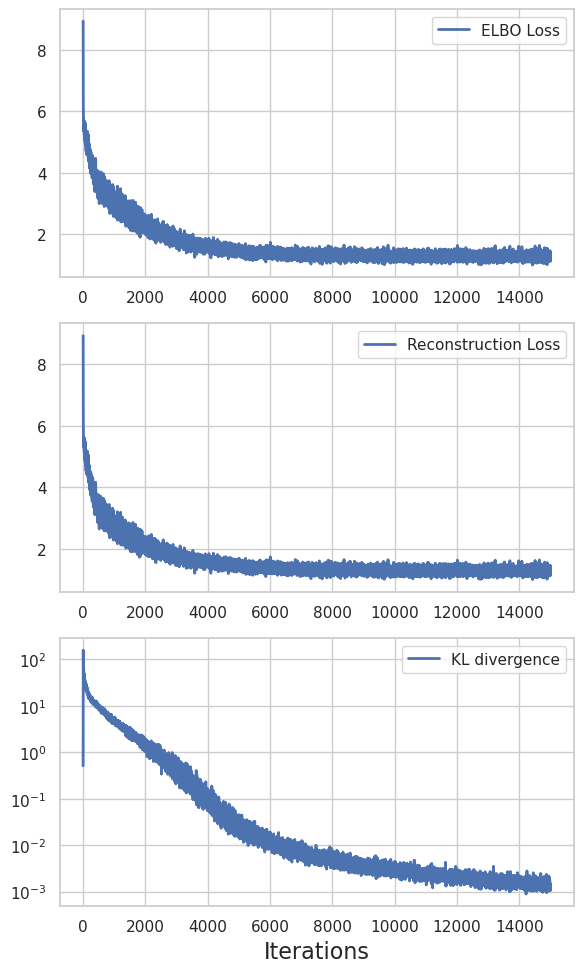

In [14]:
sns.set_theme(style='whitegrid')

fig, axes = plt.subplots(3,1,figsize=(6,9.9))

axes[0].plot(losses['LOSS_VAE'], label='ELBO Loss', linewidth=2)
axes[1].plot(losses['LOSS_RECONSTRUCTION'], label='Reconstruction Loss', linewidth=2)
axes[2].plot(losses['LOSS_KLDIVERGENCE'], label='KL divergence', linewidth=2)

#ax.set_ylabel('Loss', fontsize=16)
axes[2].set_xlabel('Iterations', fontsize=16)

axes[0].legend(loc='best')
axes[1].legend(loc='best')
axes[2].legend(loc='best')

axes[2].set_yscale('log')

plt.tight_layout()
plt.show()

In [15]:
def SMILES_generate(generator, n_to_generate, gen_data):
    generated = []
    for i in trange(n_to_generate):
        sel = generator.evaluate(gen_data)
        sel = sel.replace(gen_data.start_token, "").replace(gen_data.end_token, "")
        smi = sf.decoder(sel)
        generated.append(smi)
    return generated

In [16]:
def save_smiles(filepath, smiles):
    with open(filepath, 'w') as fout:
        for smi in smiles:
            fout.write(f"{smi}\n")
    print(f"[INFO] {len(smiles)} SMILES were saved in {filepath}")

In [17]:
n_sampling = 30000

smi_after = SMILES_generate(my_generator, n_sampling, gen_data)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30000/30000 [04:21<00:00, 114.78it/s]


In [18]:
save_smiles(os.path.join(dataconfigs.output_dir, "smi_after.csv"), smi_after)

[INFO] 30000 SMILES were saved in outputs_1_pretraining/smi_after.csv
